In [1]:
%%capture
import scikits.samplerate
import sklearn
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2
import logging
import theano.tensor as T
import lasagne
import logging
log = logging.getLogger()
log.setLevel("DEBUG")
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'png' 

import matplotlib.lines as mlines
import seaborn
seaborn.set_style('darkgrid')
matplotlib.rcParams['figure.figsize'] = (16.0, 1.0)
matplotlib.rcParams['font.size'] = 7
from braindecode.scripts.print_results import ResultPrinter
import theano
import scipy.signal
import numpy as np
from braindecode.veganlasagne.layer_util import print_layers
from braindecode.results.results import ResultPool

In [6]:
from braindecode.mywyrm.plot import ax_scalp, get_channelpos
from braindecode.datasets.sensor_positions import (get_EEG_sensors_sorted,
                                                   CHANNEL_10_20_APPROX,
                                                   WAVEGUARD_2DXYPOS,
                                                  LAURA_POS)


## Layout from waveguard site

from https://www.ant-neuro.com/products/waveguard/electrode-layouts
![Waveguard cap](https://www.ant-neuro.com/sites/default/files/images/waveguard_layout_128ch.png "Waveguard cap")

### Version 1 - Laura without interpolation to full circle

In [87]:
%%javascript
function makeSVGDownloadable() {
    $('body').on('click', 'svg', function(){
        var svg = this.outerHTML;
        var b64 = btoa(svg); // or use btoa if supported
        var linkToSVG = $("<a href-lang='image/svg+xml' href='data:image/svg+xml;base64,\n" + b64 +
                          "'title='file.svg' target='blank'>Download</a>");
        $(this).after(linkToSVG);});
}
makeSVGDownloadable()

<IPython.core.display.Javascript object>

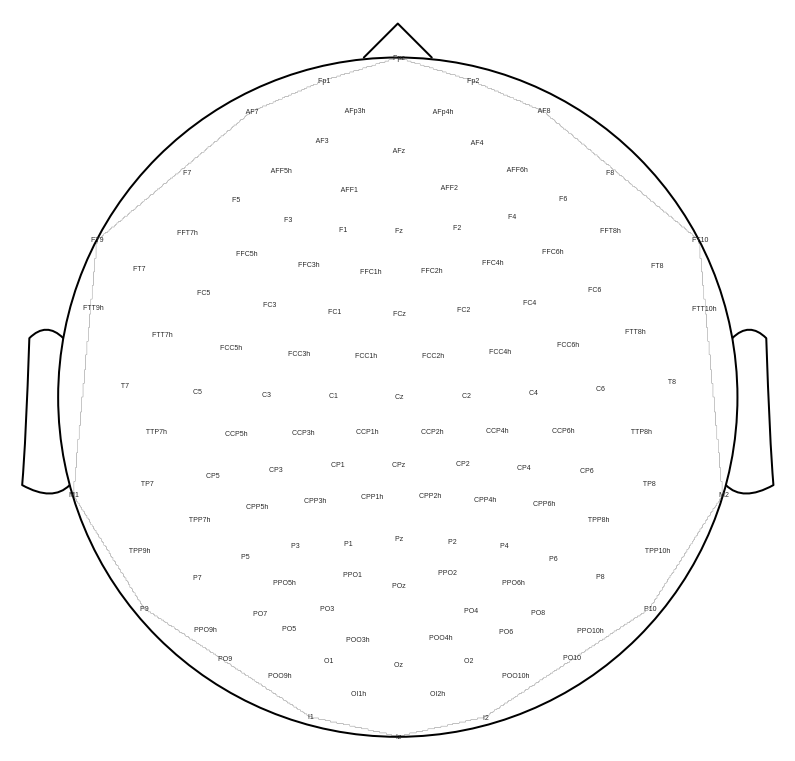

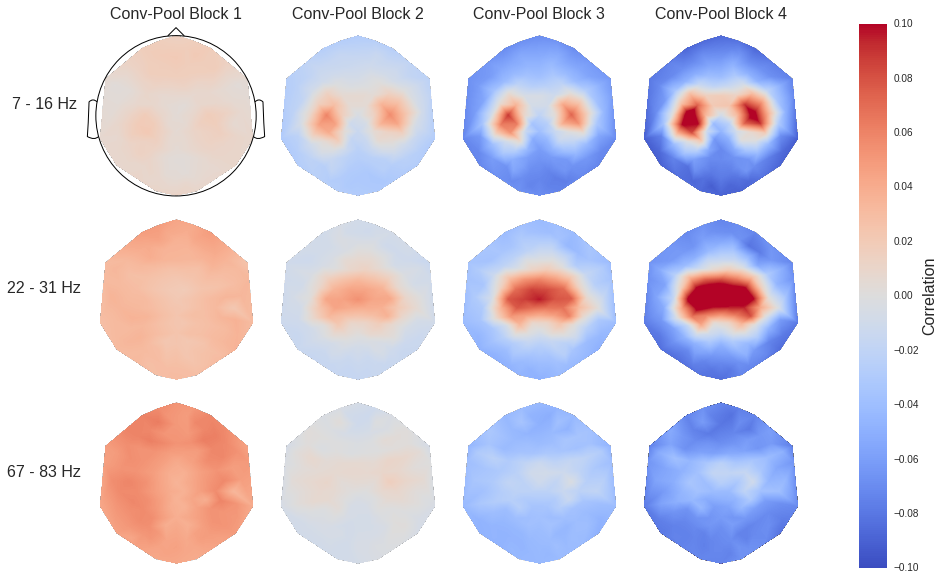

In [75]:
demo_scalpmap(LAURA_POS)

## Version 2 - Approximate Angle

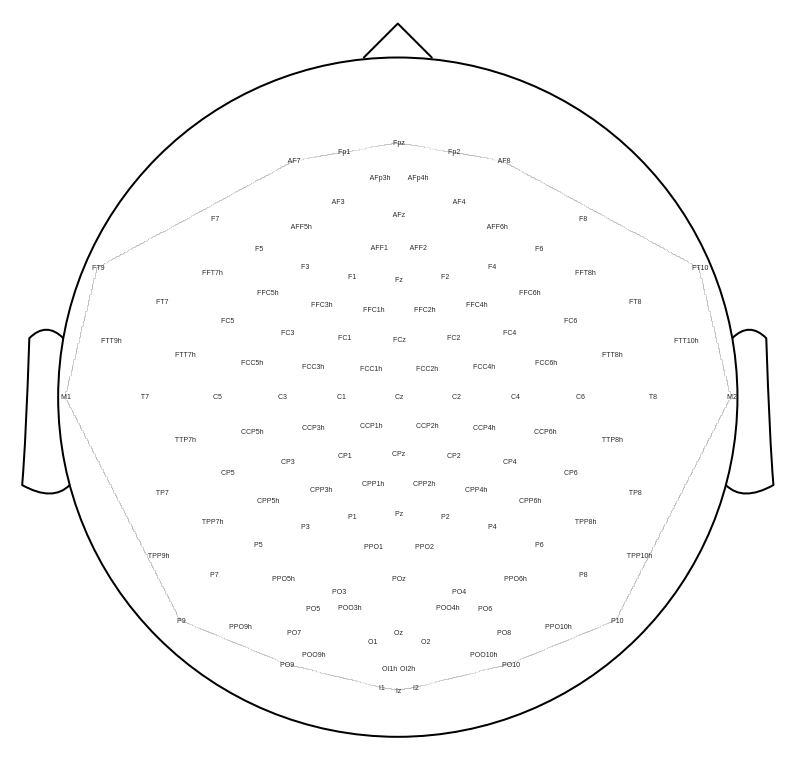

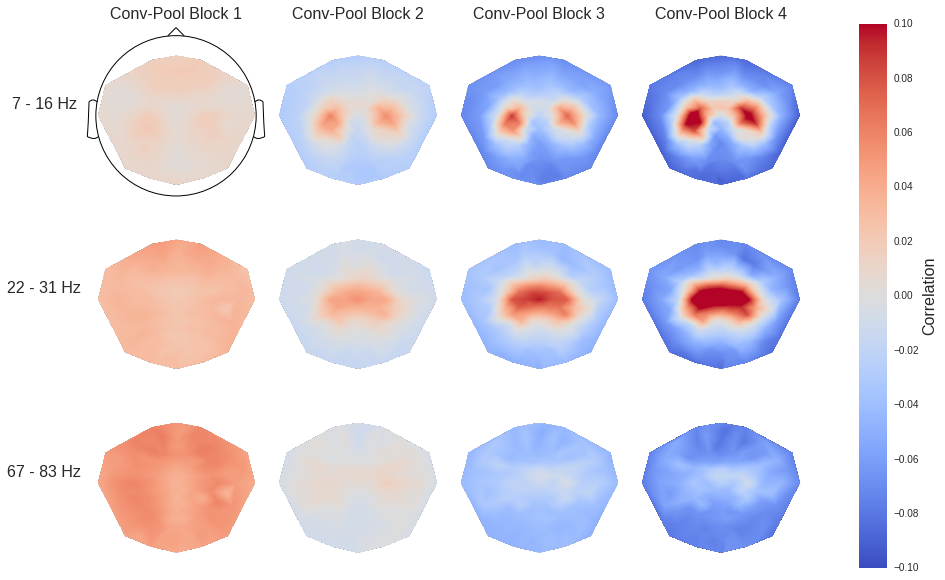

In [78]:
demo_scalpmap(CHANNEL_10_20_APPROX)

## Version 3 - Waveguard 2d XY Pos 

In [79]:
WAVEGUARD_2DXYPOS_small = [(name, (c[0] * 0.7, c[1] * 0.7)) for name, c in WAVEGUARD_2DXYPOS[1:]]

WAVEGUARD_2DXYPOS_small = tuple(['cartesian'] + WAVEGUARD_2DXYPOS_small)

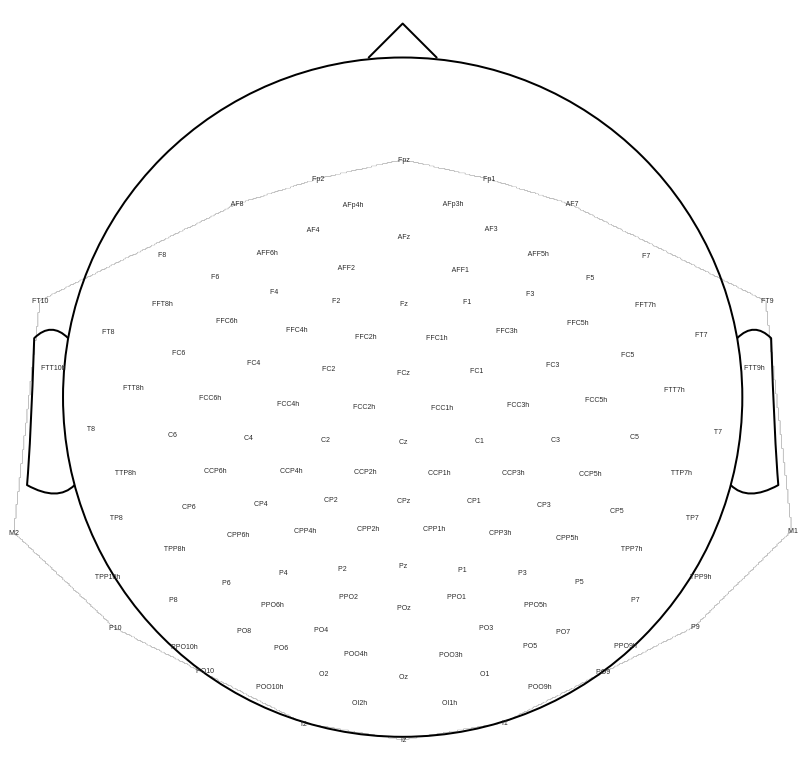

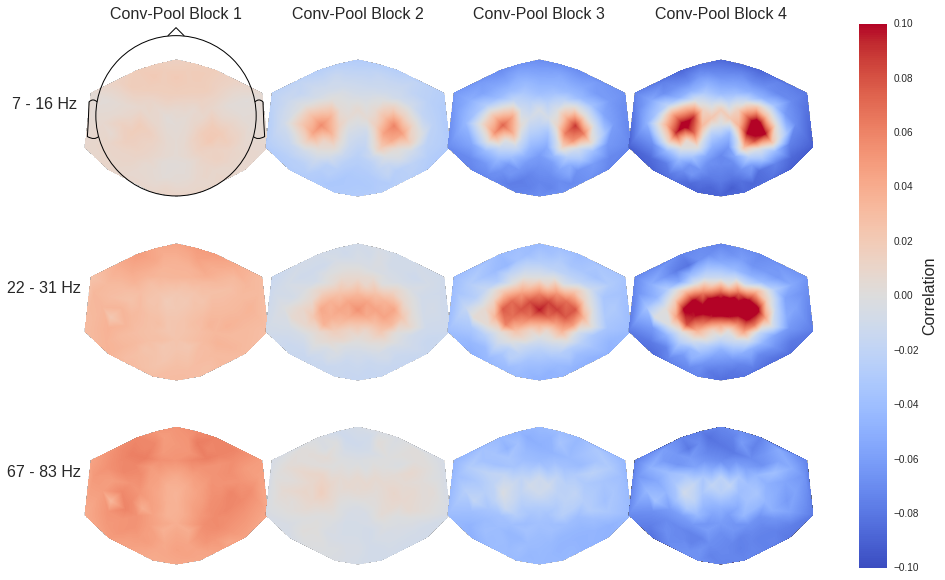

In [80]:
demo_scalpmap(WAVEGUARD_2DXYPOS_small)

In [2]:

def load_topo_corrs(folder, params, i_layer):
    result_pool = ResultPool()
    result_pool.load_results(folder, params=params)
    result_file_names = result_pool.result_file_names()
    results = result_pool.result_objects()
    # sort by dataset filename
    sort_order = np.argsort([r.parameters['dataset_filename'] for r in results])

    result_file_names = np.array(result_file_names)[sort_order]
    results = np.array(results)[sort_order]

    unclean_sets = ['AnWe', 'OlIl', 'SvMu']
    topo_corrs_per_person = []
    rand_corrs_per_person = []
    clean_mask = []
    for file_name, result in zip(result_file_names, results):
        env_corr_filename = file_name.replace('.result.pkl', '.env_corrs.{:d}.npy'.format(i_layer))
        rand_corr_filename = file_name.replace('.result.pkl', '.env_rand_corrs.{:d}.npy'.format(i_layer))

        assert os.path.isfile(env_corr_filename)
        topo_corrs = np.load(env_corr_filename)
        rand_corrs = np.load(rand_corr_filename)
        if any(s in result.parameters['dataset_filename'] for s in unclean_sets):
            clean_mask.append(False)
        else:
            clean_mask.append(True)
        topo_corrs_per_person.append(topo_corrs)
        rand_corrs_per_person.append(rand_corrs)


    rand_corrs_per_person = np.array(rand_corrs_per_person)
    topo_corrs_per_person = np.array(topo_corrs_per_person)
    clean_mask = np.array(clean_mask)
    return topo_corrs_per_person, rand_corrs_per_person, clean_mask

def load_topo_class_corrs(folder, params):
    result_pool = ResultPool()
    result_pool.load_results(folder, params=params)
    result_file_names = result_pool.result_file_names()
    results = result_pool.result_objects()
    # sort by dataset filename
    sort_order = np.argsort([r.parameters['dataset_filename'] for r in results])

    result_file_names = np.array(result_file_names)[sort_order]
    results = np.array(results)[sort_order]

    unclean_sets = ['AnWe', 'OlIl', 'SvMu']
    topo_corrs_per_person = []
    clean_mask = []
    for file_name, result in zip(result_file_names, results):
        env_corr_filename = file_name.replace('.result.pkl', '.env_corrs.class.npy')
        if not os.path.isfile(env_corr_filename): continue
        assert os.path.isfile(env_corr_filename)
        topo_corrs = np.load(env_corr_filename)
        if any(s in result.parameters['dataset_filename'] for s in unclean_sets):
            clean_mask.append(False)
        else:
            clean_mask.append(True)
        topo_corrs_per_person.append(topo_corrs)


    topo_corrs_per_person = np.array(topo_corrs_per_person)
    clean_mask = np.array(clean_mask)
    return topo_corrs_per_person, clean_mask
    


def load_topo_corrs_for_layers(folder, params, i_all_layers):
    topo_corrs_by_layer = []
    rand_corrs_by_layer= []
    for i_layer in i_all_layers:
        topo_corrs, rand_corrs, clean_mask = load_topo_corrs(folder,
                   params, i_layer)
        topo_corrs_by_layer.append(topo_corrs)
        rand_corrs_by_layer.append(rand_corrs)
    return topo_corrs_by_layer, rand_corrs_by_layer, clean_mask

In [3]:
from braindecode.datasets.generate_filterbank import generate_filterbank
filterbands = generate_filterbank(min_freq=1, max_freq=115,
        last_low_freq=31, low_width=6, low_overlap=3,
high_width=8, high_overlap=4)

def get_freq_inds(filterbands, low_freq, high_freq):
    i_low = np.where(filterbands[:,0] == low_freq)[0][0]
    i_high = np.where(filterbands[:,1] == high_freq)[0][0]
    return i_low, i_high

In [4]:
topo_corrs_by_layer, rand_corrs_by_layer, clean_mask = load_topo_corrs_for_layers(
    'data/models/paper/ours/cnt/deep4/car/',
               dict(low_cut_off_hz='null', first_nonlin='$elu',
                                    double_time_convs=False,
                                    sensor_names='$all_EEG_sensors'),
    (8,14,20,26))

In [5]:
def demo_scalpmap(chan_pos_list):
    plt.figure(figsize=(14,14))
    ax_scalp([0] * 128, get_EEG_sensors_sorted(), annotate=True, chan_pos_list=chan_pos_list)

    sensor_names = get_EEG_sensors_sorted()
    fig, axes = plt.subplots(nrows=3, ncols=4,figsize=(14,8))

    i_freq = 0
    for low,high in ((7,16),(22,31), (67,83)):
        i_freq_low, i_freq_high = get_freq_inds(filterbands,low,high)
        i_layer = 0
        for topo_corrs, rand_corrs in zip(topo_corrs_by_layer, rand_corrs_by_layer):
            scalp_line_style = 'solid'
            if i_freq == 0 and i_layer == 0:
                scalp_line_width = 1
            else:
                scalp_line_width=0
            ax = axes[i_freq][i_layer]
            if i_freq == 0:
                ax.set_title("Conv-Pool Block {:d}".format(i_layer+1), fontsize=16)
            if i_layer == 0:
                ax.set_ylabel("{:d} - {:d} Hz".format(low,high), rotation=0, fontsize=16, labelpad=40)
            topo_per_person = np.mean(np.abs(topo_corrs[clean_mask,:,i_freq_low:i_freq_high+1]), axis=(2,3))
            rand_per_person = np.mean(np.abs(rand_corrs[clean_mask,:,i_freq_low:i_freq_high+1]), axis=(2,3))
            diff = np.mean(topo_per_person - rand_per_person, axis=(0))
            contour = ax_scalp(diff,sensor_names, colormap=cm.coolwarm, vmin=-0.1, vmax=0.1, ax=ax,
                    scalp_line_width=scalp_line_width, scalp_line_style=scalp_line_style, 
                              chan_pos_list=chan_pos_list)
            i_layer += 1
        i_freq += 1



    fig.tight_layout()
    # out of ideas to make proper colorbar...
    # just make a fakeplot
    contour = ax_scalp(np.linspace(-0.1,0.1,len(sensor_names)),
                       sensor_names, colormap=cm.coolwarm, vmin=-0.1, vmax=0.1, ax=ax,
                    scalp_line_width=scalp_line_width, scalp_line_style=scalp_line_style,
                      chan_pos_list=chan_pos_list)

    cbar = fig.colorbar(contour, ax=axes.ravel().tolist())
    cbar.set_label('Correlation', fontsize=16)
    ax_scalp(diff,sensor_names, colormap=cm.coolwarm, vmin=-0.1, vmax=0.1, ax=ax,
                    scalp_line_width=scalp_line_width, scalp_line_style=scalp_line_style,
            chan_pos_list=chan_pos_list)